In [171]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [172]:
ticker = 'AXP'
START_DATE = '2020-06-30'
END_DATE = '2023-03-31'

In [173]:
x = yf.download(ticker, start=START_DATE, end=END_DATE)

[*********************100%***********************]  1 of 1 completed


In [174]:
adj_close = x['Adj Close']
returns = adj_close.pct_change().dropna()

In [175]:
train = returns['2020-06-30':'2022-08-31']
test = returns['2022-09-01':'2023-03-31']

In [176]:
T = len(test)
N = len(test)
S_0 = adj_close[train.index[-1]]
N_SIM = 100
mu = train.mean()
sigma = train.std()

In [177]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N):
   dt = T/N
   dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
   W = np.cumsum(dW, axis=1)
   time_step = np.linspace(dt, T, N)
   time_steps = np.broadcast_to(time_step, (n_sims, N))
   S_t = (
      s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps + sigma * W)
   )
   S_t = np.insert(S_t, 0, s_0, axis=1)
   return S_t

In [178]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

In [179]:
# prepare objects for plotting
LAST_TRAIN_DATE = train.index[-1].date()
FIRST_TEST_DATE = test.index[0].date()
LAST_TEST_DATE = test.index[-1].date()
PLOT_TITLE = (f'{ticker} Simulation 'f'({FIRST_TEST_DATE}:{LAST_TEST_DATE})')

In [180]:
selected_indices = adj_close[LAST_TRAIN_DATE:LAST_TEST_DATE].index
index = [date.date() for date in selected_indices]

In [181]:
gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), index=index)
V1_sim_mean = gbm_simulations_df.iloc[-1,0:].mean()
V1_sim_mean

168.99253732177115

In [182]:
V1_axp = adj_close.iloc[-1]
V1_axp

161.81056213378906

In [186]:
#Discount or premium % = ((Actual Price - Simulated Price) / Actual Price) * 100
percent_discount_or_premium = ((V1_axp-V1_sim_mean)/V1_axp) * 100

if percent_discount_or_premium > 0:
    discount_or_premium = "premium"
else:
    discount_or_premium = "discount"

print(f'Based on the mean price from 100 simulated price paths, AXP was trading at a {percent_discount_or_premium.round(4)}% {discount_or_premium} as of {END_DATE}')

Based on the mean price from 100 simulated price paths, AXP was trading at a -4.4385% discount as of 2023-03-31


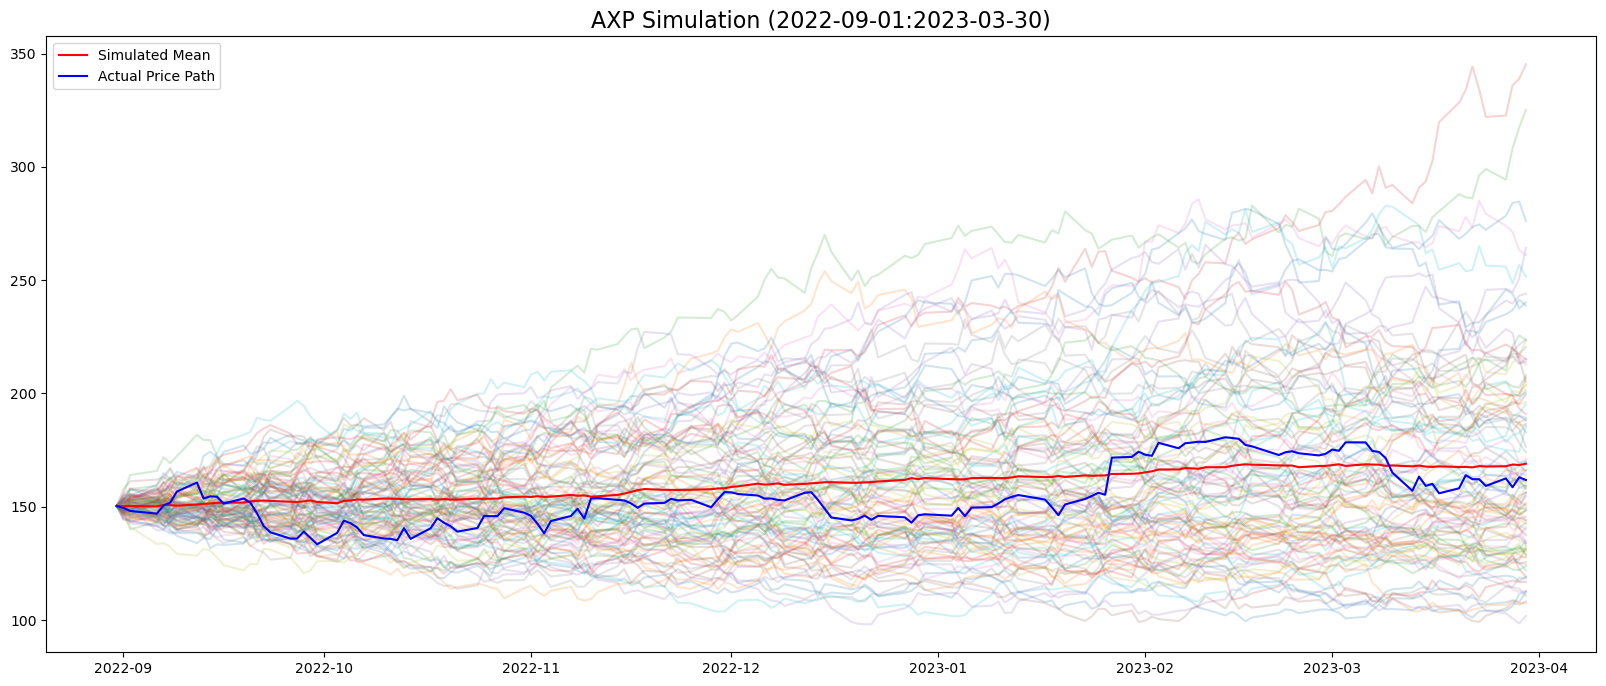

In [184]:
# plotting
ax = gbm_simulations_df.plot(figsize=(20, 8),alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), color='red')
line_2, = ax.plot(index, adj_close[LAST_TRAIN_DATE:LAST_TEST_DATE], color='blue')
ax.set_title(PLOT_TITLE, fontsize=16)
ax.legend((line_1, line_2), ('Simulated Mean', 'Actual Price Path'))

plt.show()